Changelog:  (Last Updated 2023-03-09)

# Probabilistic ML: Assignment 3
- **Deadline**: 2023-03-27 (March 27th 2023)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [1]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=473429d3ac233b5773a3af213cfda2e45741824639fa35aed65de831a213e20a
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [2]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [3]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [4]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')
    
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [5]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.
    x = torch.randn(num_samples, mean.shape[0])
    return (x) * torch.exp(log_std) + mean


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a 
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    samples = diag_gaussian_samples(mean, log_std, num_samples)
    return torch.mean(logprob(samples) - diag_gaussian_logpdf(samples, mean, log_std), axis=0)


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [6]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, params[0], params[1], num_samples_per_iter)

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Almost initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  9%|▉         | 72/800 [00:00<00:03, 198.29it/s]

Iteration 0 lower bound 21.005210876464844
Iteration 25 lower bound 13.940927505493164
Iteration 50 lower bound 12.142265319824219


 18%|█▊        | 146/800 [00:00<00:02, 283.16it/s]

Iteration 75 lower bound 7.1862406730651855
Iteration 100 lower bound 9.405525207519531
Iteration 125 lower bound 4.673096179962158


 22%|██▏       | 179/800 [00:00<00:02, 241.21it/s]

Iteration 150 lower bound 6.348623275756836
Iteration 175 lower bound 4.747806549072266


 30%|██▉       | 237/800 [00:01<00:02, 258.82it/s]

Iteration 200 lower bound 4.7128987312316895
Iteration 225 lower bound 4.219322204589844
Iteration 250 lower bound 3.2404541969299316


 38%|███▊      | 304/800 [00:01<00:01, 269.89it/s]

Iteration 275 lower bound 3.674623727798462
Iteration 300 lower bound 3.3908658027648926
Iteration 325 lower bound 3.4621005058288574


 51%|█████     | 407/800 [00:01<00:01, 316.14it/s]

Iteration 350 lower bound 3.1456360816955566
Iteration 375 lower bound 3.4124584197998047
Iteration 400 lower bound 2.918494462966919


 60%|█████▉    | 477/800 [00:01<00:01, 317.99it/s]

Iteration 425 lower bound 3.0772058963775635
Iteration 450 lower bound 4.040598392486572
Iteration 475 lower bound 2.7784104347229004


 69%|██████▉   | 550/800 [00:02<00:00, 335.96it/s]

Iteration 500 lower bound 3.573965549468994
Iteration 525 lower bound 3.0221147537231445
Iteration 550 lower bound 3.1363158226013184
Iteration 575 lower bound 2.7865755558013916


 82%|████████▏ | 655/800 [00:02<00:00, 320.77it/s]

Iteration 600 lower bound 3.1584458351135254
Iteration 625 lower bound 2.740582227706909
Iteration 650 lower bound 2.7743406295776367


 90%|█████████ | 723/800 [00:02<00:00, 320.49it/s]

Iteration 675 lower bound 3.1393256187438965
Iteration 700 lower bound 3.005293607711792
Iteration 725 lower bound 2.9527711868286133


100%|██████████| 800/800 [00:02<00:00, 285.68it/s]

Iteration 750 lower bound 2.852876901626587
Iteration 775 lower bound 3.0491738319396973



/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


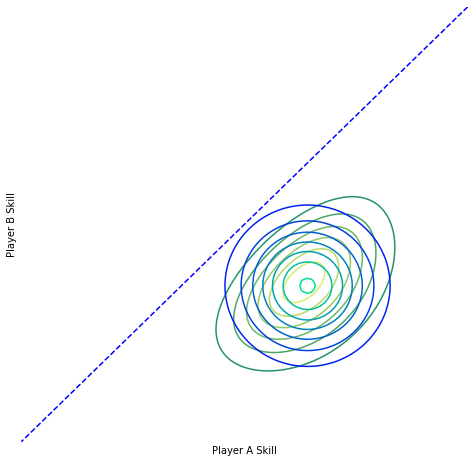

<Figure size 432x288 with 0 Axes>

In [7]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std  = torch.ones(D, requires_grad=True)# TODO.
init_mean = torch.zeros(D, requires_grad=True) # TODO

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**d) [3pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [8]:
# Hyperparameters
n_iters = 200
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_beat_each_other_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, params[0], params[1], num_samples_per_iter)

**e) [3pts]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

--- 

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 12%|█▏        | 23/200 [00:00<00:00, 226.39it/s]

Iteration 0 lower bound 32.601844787597656
Iteration 25 lower bound 31.258974075317383


 45%|████▌     | 90/200 [00:00<00:00, 186.03it/s]

Iteration 50 lower bound 21.04840087890625
Iteration 75 lower bound 21.231538772583008


 74%|███████▍  | 148/200 [00:00<00:00, 236.48it/s]

Iteration 100 lower bound 18.199766159057617
Iteration 125 lower bound 18.630645751953125
Iteration 150 lower bound 17.23354721069336


100%|██████████| 200/200 [00:00<00:00, 220.30it/s]


Iteration 175 lower bound 17.05588150024414


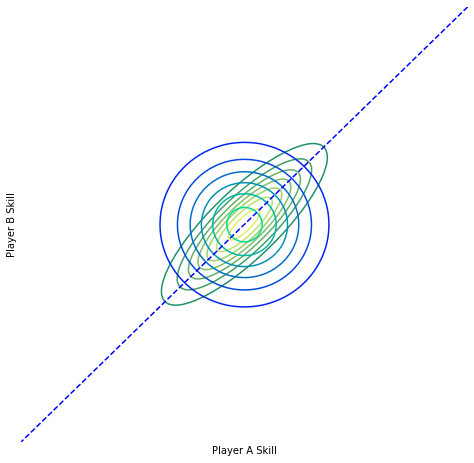

<Figure size 432x288 with 0 Axes>

In [9]:
# Main loop. 
# Reinitialize with the same initialization as you did in 1c) . 
init_log_std  = torch.ones(D, requires_grad=True)# TODO.
init_mean = torch.zeros(D, requires_grad=True) # TODO
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

From the plot above, we can see that the areas where the approximate posterior (plotted in blue) does not overlap with the actual posterior (plotted in green) are where A and B both have very high skill level or if both have very low skill levels. In these situations, this is plausible under the real posterior but not under the approximate posterior. 

Yes, the approximation would be better since the correlation between player A and player B would also be included in the approximate posterior instead of simply a digonal covariance Gaussian which does not include this correlation.

## 1.2 [30 pts] Approximate inference conditioned on real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [10]:
wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [11]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs] 
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [12]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [13]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)

**c) [3pts]** Optimize, and report the final loss. 

In [14]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

Optimizing variational parameters...


  0%|          | 1/500 [00:00<01:07,  7.36it/s]

Iteration 0 lower bound 2310.2021484375


  5%|▌         | 27/500 [00:02<00:37, 12.59it/s]

Iteration 25 lower bound 2196.602294921875


 11%|█         | 53/500 [00:04<00:35, 12.70it/s]

Iteration 50 lower bound 2068.2236328125


 16%|█▌        | 78/500 [00:05<00:36, 11.68it/s]

Iteration 75 lower bound 1986.4300537109375


 20%|██        | 102/500 [00:08<00:41,  9.51it/s]

Iteration 100 lower bound 1917.55712890625


 25%|██▌       | 127/500 [00:10<00:34, 10.69it/s]

Iteration 125 lower bound 1860.962890625


 30%|███       | 151/500 [00:12<00:30, 11.27it/s]

Iteration 150 lower bound 1811.8533935546875


 35%|███▌      | 176/500 [00:15<01:01,  5.29it/s]

Iteration 175 lower bound 1784.2623291015625


 41%|████      | 204/500 [00:18<00:20, 14.39it/s]

Iteration 200 lower bound 1750.9776611328125


 46%|████▌     | 228/500 [00:20<00:20, 13.60it/s]

Iteration 225 lower bound 1722.736083984375


 50%|█████     | 252/500 [00:22<00:23, 10.66it/s]

Iteration 250 lower bound 1702.3824462890625


 55%|█████▌    | 277/500 [00:24<00:16, 13.63it/s]

Iteration 275 lower bound 1689.361572265625


 61%|██████    | 303/500 [00:25<00:16, 12.11it/s]

Iteration 300 lower bound 1669.463623046875


 65%|██████▌   | 327/500 [00:28<00:30,  5.73it/s]

Iteration 325 lower bound 1650.51953125


 71%|███████   | 353/500 [00:31<00:14, 10.40it/s]

Iteration 350 lower bound 1641.55859375


 75%|███████▌  | 377/500 [00:33<00:09, 13.58it/s]

Iteration 375 lower bound 1630.9783935546875


 81%|████████  | 403/500 [00:35<00:07, 13.48it/s]

Iteration 400 lower bound 1620.6937255859375


 86%|████████▌ | 430/500 [00:37<00:03, 22.13it/s]

Iteration 425 lower bound 1613.3983154296875


 91%|█████████ | 456/500 [00:38<00:01, 29.06it/s]

Iteration 450 lower bound 1605.1712646484375


 96%|█████████▌| 480/500 [00:39<00:00, 24.68it/s]

Iteration 475 lower bound 1600.4508056640625


100%|██████████| 500/500 [00:39<00:00, 12.55it/s]


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

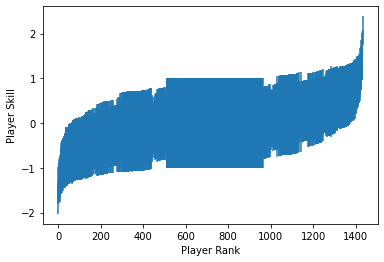

In [15]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], torch.exp(logstd_skills[order]) ** 2)

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [16]:
for i in range(1,11):
  print(names[order[-i].item()][1])

doraemon61
laode_syahril
projetoxadrez
mrzoom47
chesswithmom
cdvh
hick4u1219
smartduckduckcow
sneaky_bugger
lzchips


**f) [3pt]** Plot samples from the joint posterior over the skills of lelik3310 and thebestofthebad. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

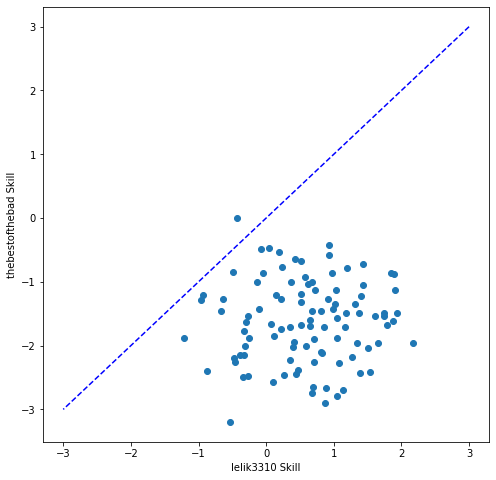

In [17]:
lelik3310_ix = 496
thebestofthebad_ix = 512

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill") 
plt.ylabel("thebestofthebad Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)
plt.scatter(samples[:, lelik3310_ix], samples[:, thebestofthebad_ix])
# TODO:  Hint:  Use plt.scatter()

Based on the samples, lelik3310 has higher skill than thebestofthebad since most/all of the scatter points lie below the "line of equal skill" towards the x axis.

**g) [6pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim N (\mu, \Sigma)$, then $AX \sim  N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim N (\mu_i , \Sigma_{ii})$.

If we use a change of variables $y_A, y_B = z_A - z_B, z_B$, the line of equal skill looks like a vertical line (if we plot $y_A$ on the x-axis, $y_B$ on the y-axis) at 0 (since $y_A$ measures the skill gap betwen A and B).

A matrix that satisfies this transformation would be $A = \begin{bmatrix}
1 & -1 \\
0 & 1
\end{bmatrix}$. Note that if we take this matrix and multiply it by a vector $z = (z_A, z_B)^T$, we get $(z_A - z_B, z_B)^T$ as required.

Now, let $\mu = (\mu_A, \mu_B)^T$ and $\Sigma = \begin{bmatrix}
\sigma_A^2 & 0\\
0 & \sigma_B^2
\end{bmatrix}$. We know the covariance matrix is diagonal because the Gaussian is factorized.

Then $A\mu = (\mu_A - \mu_B, \mu_B)^T$ and 
$$A\Sigma A^T = \begin{bmatrix}
1 & -1 \\
0 & 1
\end{bmatrix} \begin{bmatrix}
\sigma_A^2 & 0\\
0 & \sigma_B^2
\end{bmatrix}\begin{bmatrix}
1 & 0 \\
-1 & 1
\end{bmatrix}\\
=\begin{bmatrix}
\sigma_A^2 & -\sigma_B^2\\
0 & \sigma_B^2
\end{bmatrix}\begin{bmatrix}
1 & 0 \\
-1 & 1
\end{bmatrix}\\
=\begin{bmatrix}
\sigma_A^2 + \sigma_B^2 & -\sigma_B^2\\
-\sigma_B^2 & \sigma_B^2
\end{bmatrix}$$

Where $AX \sim N(A\mu, A\Sigma A^T)$.
We want the first element of AX, since that represents $y_A = z_A - zB$ which is the difference between the two players' skill levels.

Then the marginal distribution the first element of $AX$ is simply $N(\mu_A - \mu_B, \sigma_A^2 + \sigma_B^2).$ Assuming we want $P(z_A > z_B)$ based on $z_A$ being the player of interest having higher skill than $z_B$, we want

 $P(y_A > 0) = 1 - P(y_A < 0) = 1 - CDF(y_A, 0)$ 

where $y_A$ is marked by the marginal distribution we specified above. 

**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [18]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    post_mean = (mean_skills[lelik3310_ix] - mean_skills[thebestofthebad_ix])
    stds = torch.exp(logstd_skills)
    post_std = np.sqrt(stds[lelik3310_ix] ** 2 + stds[thebestofthebad_ix] ** 2)
    formula_est = (1 - Normal(post_mean, post_std).cdf(torch.zeros(1))).item()
    samples = diag_gaussian_samples(mean_skills, logstd_skills, N)
    mc_est = (samples[:, lelik3310_ix] > samples[:, thebestofthebad_ix]).sum() / N
    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9860881567001343
Simple MC Estimate: 0.9840999841690063


**i) [2pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [19]:
# TODO
fifth_worst_ix = mean_skills[4]
formula_est1, mc_est1 = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact CDF Estimate: {formula_est1}")
print(f"Simple MC Estimate: {mc_est1}")

Exact CDF Estimate: 0.9860881567001343
Simple MC Estimate: 0.9869999885559082


**j) [3 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

No, it wouldn't. The exact probability that we calculate is derived from the difference in the mean of the two players' skills, and since the prior on all the players is still the same, in expectation, the difference should be the same for both of the questions above. For the quantity computed with simple Monte Carlo, the same logic applies - the mean skills are all "shifted" by 10 upwards, and therefore comparing the skills of two players based on a sample will still remain the same.

**k) [3 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Based on the plots, the MCMC algorithm appears to be a better overall approximation to the true posterior. If we look in assignment 2 and view the plots, the sampled points from the MCMC algorithm fit reliably inside the contour lines and MCMC seems to give the exact posterior, whereas the inference method with ELBO does not seem to align the approximate and exact posterior.

# 2. [50pts] Expectation-Maximization (EM) algorithm



In [20]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2.1 [7pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = N(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [21]:
num_samples = 400
cov = np.array([[10, 7], [7, 10]]) # TODO
mean_1 = np.array([0.1, 0.1]) # TODO
mean_2 = np.array([6.0, 0.1]) # TODO

x_class1 = np.random.multivariate_normal(mean_1, cov, size=(num_samples//2)) # TODO
x_class2 = np.random.multivariate_normal(mean_2, cov, size=(num_samples//2)) # TODO
xy_class1 = np.append(x_class1, np.ones((x_class1.shape[0], 1)), axis=1) # TODO
xy_class2 = np.append(x_class2, np.ones((x_class2.shape[0], 1)) * 2, axis=1) # TODO

data_full = np.append(xy_class1, xy_class2, axis=0) # TODO complete data
np.random.shuffle(data_full)
data = data_full[:, :2] # TODO incomplete data
labels = data_full[:, 2] # TODO


**b) [2pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

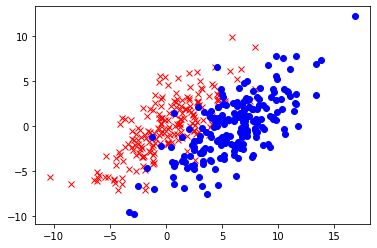

In [22]:
plt.plot(x_class1[:, 0], x_class1[:, 1], 'rx') # first class, x shape
plt.plot(x_class2[:, 0], x_class2[:, 1], 'bo') # second class, circle shape

## 2.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat{\mu}_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat{\mu}_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error. 

**a) [2pts]** Complete the `cost` function.

In [23]:
def cost(data, R, Mu):
    N, D = data.shape # TODO
    K = Mu.shape[1] # TODO
    # TODO
    r = np.zeros((N, K)) # TODO
    # TODO assign all r[:, k]
    for k in range(K):
      r[:, k] = np.linalg.norm(data - np.repeat(Mu[:, k], N).reshape((N, D)), axis=1)

    # print((data - np.repeat(Mu[:, k], N).reshape((N, D))))
    # here, r[n, k] is the norm between the nth data point and the kth cluster mean
    J = np.sum(R * r)
    
    return J

**b) [4pts]** K-Means assignment step.

In [24]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape # TODO: Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of clusters
    r = np.zeros((N, K)) # TODO
    # TODO assign all r[:, k]
    for k in range(K):
      r[:, k] = np.linalg.norm(data - np.repeat(Mu[:, k], N).reshape((N, D)), axis=1)

    arg_min = np.argmin(r, axis=1) # TODO: argmax/argmin along dimension 1
    R_new = np.zeros((N, K)) # TODO: Set to zeros/ones with shape (N, K)
    R_new[list(range(N)), arg_min] = 1 # TODO Assign to 1
    return R_new

**c) [2pts]** K-Means refitting step.

In [25]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape # TODO: number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO: number of clusters
    #Rnk is 0 if not closest to kth Mu, and 1 if it is. So the Rnth row times 
    #R.T.dot(data) is K times D matrix, where the kth cluster 
    Mu_new = R.T.dot(data).T / np.sum(R, axis=0) # divide by the sum of number of items in each cluster
    return Mu_new

**d) [4pts]** Run this cell to call the K-Means algorithm.

In [26]:
N, D = 400, 2
K = 2
max_iter = 100
class_init = np.append(np.ones(200), 2 * np.ones(200))
R = np.zeros((N, K))

Mu = np.zeros([D, K])
Mu[:, 1] = 1.
R.T.dot(data), np.sum(R, axis=0)
costs = []
for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    print(it, cost(data, R, Mu))
    costs.append(cost(data, R, Mu))
class_1 = (np.argmax(R, axis=1) == 0).nonzero()
class_2 = (np.argmax(R, axis=1) == 1).nonzero()

0 1818.5957228190011
1 1707.6583354505728
2 1705.3653359762811
3 1703.2141487946838
4 1703.2141487946838
5 1703.2141487946838
6 1703.2141487946838
7 1703.2141487946838
8 1703.2141487946838
9 1703.2141487946838
10 1703.2141487946838
11 1703.2141487946838
12 1703.2141487946838
13 1703.2141487946838
14 1703.2141487946838
15 1703.2141487946838
16 1703.2141487946838
17 1703.2141487946838
18 1703.2141487946838
19 1703.2141487946838
20 1703.2141487946838
21 1703.2141487946838
22 1703.2141487946838
23 1703.2141487946838
24 1703.2141487946838
25 1703.2141487946838
26 1703.2141487946838
27 1703.2141487946838
28 1703.2141487946838
29 1703.2141487946838
30 1703.2141487946838
31 1703.2141487946838
32 1703.2141487946838
33 1703.2141487946838
34 1703.2141487946838
35 1703.2141487946838
36 1703.2141487946838
37 1703.2141487946838
38 1703.2141487946838
39 1703.2141487946838
40 1703.2141487946838
41 1703.2141487946838
42 1703.2141487946838
43 1703.2141487946838
44 1703.2141487946838
45 1703.214148794683

**e) [2pts]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


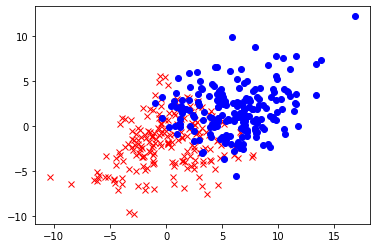

In [27]:
plt.plot(data[class_1, 0], data[class_1, 1], 'rx'); # TODO first class, x shape
plt.plot(data[class_2, 0], data[class_2, 1], 'bo'); # TODO second class, circle shape

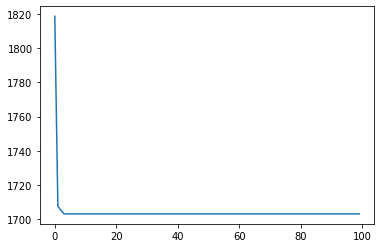

In [28]:
plt.plot(list(range(max_iter)), costs)

## 2.3 [21pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$ for the covariances.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [29]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [30]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    N, D = data.shape  # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    L, T = 0., 0.
    # TODO: given n, k, compute the likelihood from the k-th Gaussian weighted by the mixing coefficients
    vals = np.zeros((N, K))
    for n in range(N):
      for k in range(K):
        vals[n, k] = normal_density(data[n, :], Mu[:, k], Sigma[k])
    T = Pi.dot(vals.T)
    L = np.sum(np.log(T))
    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [31]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    Gamma = np.zeros((N, K)) # TODO zeros of shape (N,K), matrix of responsibilities
    for n in range(N):
      for k in range(K):
        Gamma[n, k] = normal_density(data[n, :], Mu[:, k], Sigma[k])
    # TODO: given n, k, normalize by sum across second dimension (mixtures)
    Gamma = Gamma / np.sum(Gamma, keepdims=True, axis=1)
    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [32]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Gamma.shape[1]  # TODO number of mixtures
    Nk = np.sum(Gamma, axis=0) # TODO Sum along first axis 
    Mu = data.T.dot(Gamma) / Nk # TODO
    Sigma = []
    for k in range(K):
      Sigma.append((Gamma[:, k].reshape((N, 1)) * (data - Mu[:, k])).T.dot((data - Mu[:, k])) / Nk[k])
    # TODO: fill in Sigma[k] for each k

    Pi = Nk / N # TODO
    return Mu, Sigma, Pi

**d) [4pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [33]:
N, D = 400, 2
K = 2
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

max_iter  = 200
lls = []
for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi)
    Mu, Sigma, Pi = gm_m_step(data, Gamma)
    lls.append(log_likelihood(data, Mu, Sigma, Pi))

class_1 = (np.argmax(Gamma, axis=1) == 0).nonzero()
class_2 = (np.argmax(Gamma, axis=1) == 1).nonzero()

**e) [2pts]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

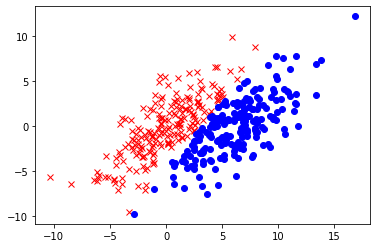

In [34]:
plt.plot(data[class_1, 0], data[class_1, 1], 'rx'); # TODO first class, x shape
plt.plot(data[class_2, 0], data[class_2, 1], 'bo'); # TODO second class, circle shape

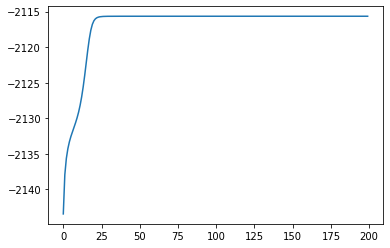

In [35]:
plt.plot(list(range(max_iter)), lls)

## 2.4 [8pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]
 


If we compare the plots side by side, we can see that the EM algorithm performs much better in terms of cluster assignments (is closer to original data clusters) than the k-Means. 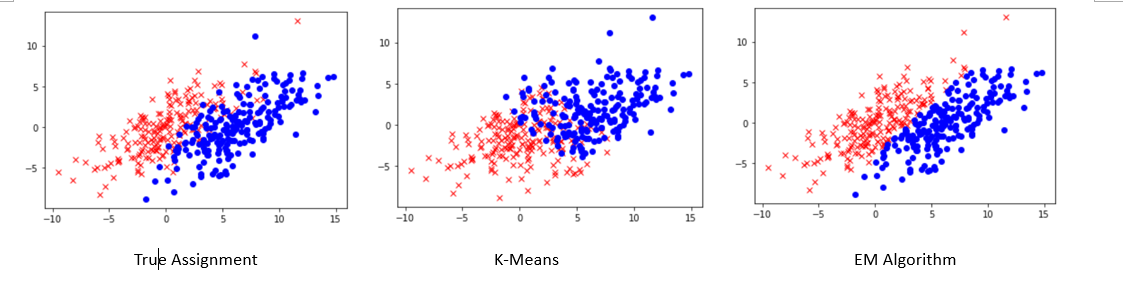

However, we can also see through the two graphs over the iterations that the cost (for k-means) takes only 6-7 iterations (less than 10) to converge, while the log likelihood (for the EM algorithm) takes 30-40 iterations to converge which is significantly more. The bottleneck for the K-Means algorihtm is the assignment step for the matrix R, where we have to calculate the norms for the differences between the vectors and the cluster means. For the EM algorithm, calculating the covariance matrices in the maximization step is the bottleneck.

After running the code 5 separate times (so that the data is generated randomly the same way 5 different times), we reach several conclusions (with the cluster assignments shown below). Firstly, the performance of the K-Means algorithm and the EM algorithm as described above holds in every instance - the EM algorithm is always more accurate (decidedly so) than the K-Means by being much closer to the true assignment of the clusters, and always takes more iterations to converge. That being said, the number of iterations that the K-Means algorithm takes to converge is almost always around 5-7 iterations, while the K-Means algorithm has a larger variance of iterations to converge (ranging from 15 to 60 depending on the data).

In addition, we can see that the K-Means algorithm is much more comfortable with assigning points to clusters that overlap in all of the trials. However, the EM algorithm seems to always have an almost linear boundary of division between clusters.

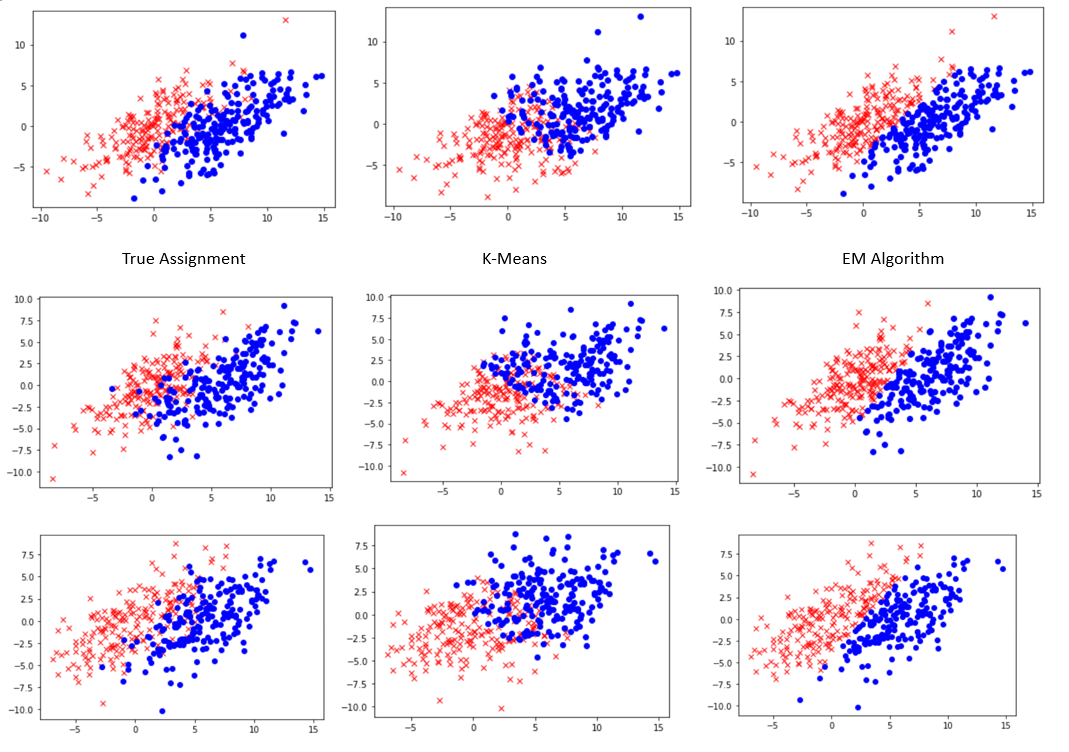

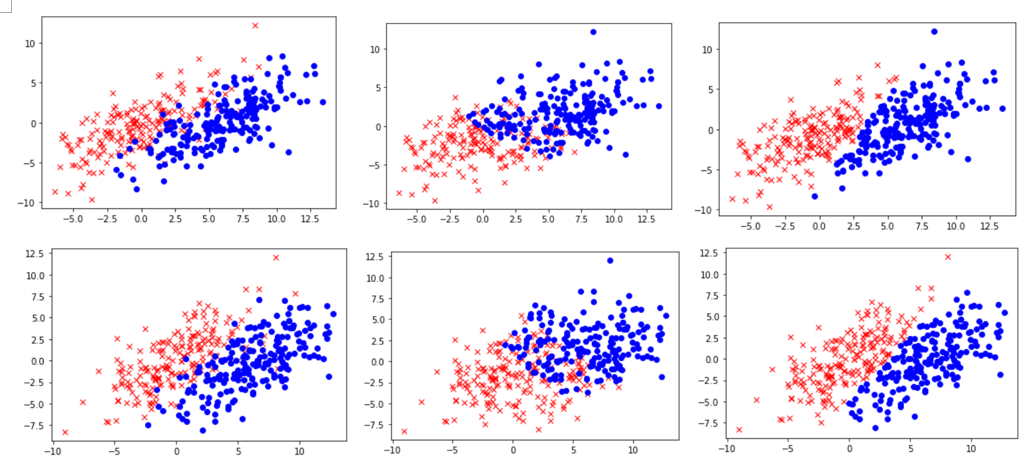

If we increased the number of clusters K, the number of potential clusters to assign to increases as well. Hence, I'd expect to see more misclassifications with both algorithms. With regard to the EM algorithm, we noted that the boundary for decision seemed to be linear - with more clusters, we'd probably see something very similar with "strict" clusters and without any overlap, while overlap is more likely with more clusters. Hence, the misclassification rate may be higher.